### Key factors that influence US home prices nationally.

**AIM -** Using publically available data for the national factors that impact supply and demand of homes in US, build a model to study the effect of these variables on home prices.

**STEPS -** Two factors influence the house price SUPPLY eg New buliding , supply of housing , Number of selling , house inventory  and DEMAND eg GDP , Interest rate , Median Salarian , Consumer Sentiment , Unemployment. Some of the  factors under chosen for the study-

- Per Capita GDP
- Interest Rates
- House Inventory
- Median Income
- PPI(Production Price Index) Construction material 
- GDP Growth Rate (Consumer Sentiments)


As a proxy to the home prices, S&P CASE-SHILLER Index is used. 

Most of the data is downloaded from [https://fred.stlouisfed.org/].

Data for all the variables is downloaded, preprocessed and combined to create a datset. Data for different variables had different frequencies. So, to combine the data, necessary interpolations are made.

Linear Regression is used as most of the variables have high correlation with the target variable. As well as other Regression model were attempted too explore which model is best suited for this type of data e.g: DT,RF,KNN,Adaboost,XgBoost

In [158]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [159]:
#Reading CASE-SHILLER home price Index into a dataframe(DAILY DATA)
data = pd.read_csv("US_HousePrice_Index.csv" ,  parse_dates=['observation_date'], dayfirst=True )
print(data)

    observation_date  CSUSHPISA
0         1987-01-01     63.965
1         1987-02-01     64.424
2         1987-03-01     64.736
3         1987-04-01     65.132
4         1987-05-01     65.563
..               ...        ...
436       2023-05-01    302.566
437       2023-06-01    304.593
438       2023-07-01    306.767
439       2023-08-01    309.155
440       2023-09-01    311.175

[441 rows x 2 columns]


In [160]:
data.dtypes

observation_date    datetime64[ns]
CSUSHPISA                  float64
dtype: object

In [161]:
#Rename date column 
data = data.rename(columns = {'observation_date' : 'DATE'})
print(data.dtypes)

DATE         datetime64[ns]
CSUSHPISA           float64
dtype: object


In [162]:
# #Changing dtype of date column
# data["DATE"] = pd.to_datetime(data["DATE"])
# print(data.dtypes)
#Selecting data post JAN 2003
post_date = data["DATE"] >= "2003-01-01"
data = data[post_date]

#Resetting Index
data.reset_index(inplace = True)
data.drop(columns = ["index"], inplace = True)

# Creating "Year" and "Month" columns
data["Year"] = pd.DatetimeIndex(data["DATE"]).year
data["Month"] = pd.DatetimeIndex(data["DATE"]).month
print(data.shape)

data.head(5)

(249, 4)


,DATE,CSUSHPISA,Year,Month
0,2003-01-01,128.461,2003,1
1,2003-02-01,129.355,2003,2
2,2003-03-01,130.148,2003,3
3,2003-04-01,130.884,2003,4
4,2003-05-01,131.735,2003,5


In [163]:
# Reading GDP Data into a dataframe (QUARTERLY DATA)
data_gdp = pd.read_csv("GDP.csv" , parse_dates=['DATE'], dayfirst=True)
print(data_gdp.dtypes)
print(data_gdp.shape)
data_gdp.head(5)

DATE    datetime64[ns]
GDP            float64
dtype: object
(83, 2)


,DATE,GDP
0,2003-01-01,11174.129
1,2003-04-01,11312.766
2,2003-07-01,11566.669
3,2003-10-01,11772.234
4,2004-01-01,11923.447


In [164]:
# Reading MortgageRate last 30 years - MORTGAGE30 (WEEKLY DATA)
 
data_morg = pd.read_csv("MORTGAGE30US.csv",parse_dates=['DATE'], dayfirst=True)
print(data_morg.shape)
#Rename date column 
data_morg = data_morg.rename(columns = {'observation_date' : 'DATE'})
print(data_morg.dtypes)
data_morg.head(5)

(1093, 2)
DATE            datetime64[ns]
MORTGAGE30US           float64
dtype: object


,DATE,MORTGAGE30US
0,2003-01-03,5.85
1,2003-01-10,5.95
2,2003-01-17,5.97
3,2003-01-24,5.91
4,2003-01-31,5.90


In [165]:
# Reading Real Median Household Income National Level U.S (YEARLY DATA)

data_income = pd.read_csv("Real Median Income.csv", names = ["DATE", "Income"], skiprows = 30 , 
                          parse_dates=['DATE'], dayfirst=True)
print(data_income.shape)
print(data_income.dtypes)

# #Change date dtypes
# data_income["DATE"] = pd.to_datetime(data_income["DATE"])
# print(data_income.dtypes)
data_income.head(5)

(20, 2)
DATE      datetime64[ns]
Income             int64
dtype: object


,DATE,Income
0,2003-01-01,65860
1,2004-01-01,65760
2,2005-01-01,66780
3,2006-01-01,67520
4,2007-01-01,68610


In [166]:
# Reading Housing Inventory(number of vacant house:new+old) (QUARTERLY DATA)

data_housevacant= pd.read_csv("Vacant_House.csv", names = ["DATE", "Num_Vacant_House"], skiprows = 22 ,
                              parse_dates=['DATE'], dayfirst=True )
print(data_housevacant.shape)
print(data_housevacant.dtypes)
#Change date dtypes
# data_housevacant["DATE"] = pd.to_datetime(data_housevacant["DATE"])
# print(data_housevacant.dtypes)

data_housevacant.head(5)

(83, 2)
DATE                datetime64[ns]
Num_Vacant_House             int64
dtype: object


,DATE,Num_Vacant_House
0,2003-01-01,14908
1,2003-04-01,15244
2,2003-07-01,15614
3,2003-10-01,15654
4,2004-01-01,15895


In [167]:
# Reading GDP Growth Rate Data into a dataframe (QUARTERLY DATA) - NEEDED FOR COUSUMER SENTIMENT 
data_growth = pd.read_csv("GDP_growthrate_quat.csv" , parse_dates=['DATE'], dayfirst=True)
print(data_growth.shape)
#Rename date column 
data_growth = data_growth.rename(columns = {'A191RP1Q027SBEA' : 'GDP Growth rate'})
print(data_growth.dtypes)
data_growth.head(5)

(82, 2)
DATE               datetime64[ns]
GDP Growth rate           float64
dtype: object


,DATE,GDP Growth rate
0,2003-04-01,5.1
1,2003-07-01,9.3
2,2003-10-01,7.3
3,2004-01-01,5.2
4,2004-04-01,6.5


In [168]:
#PPI - Construction material cost (DAILY DATA) - major factor deciding cost rise after 2015 and onwards
data_cost = pd.read_csv("PPI_CONST_MATE.csv",parse_dates=['DATE'], dayfirst=True)
print(data_cost.shape)
#Rename date column 
data_cost = data_cost.rename(columns = {'WPUSI012011':'Construstion material cost'})
print(data_cost.dtypes)
data_cost.head(5)

(250, 2)
DATE                          datetime64[ns]
Construstion material cost           float64
dtype: object


,DATE,Construstion material cost
0,2003-01-01,144.4
1,2003-02-01,145.2
2,2003-03-01,145.2
3,2003-04-01,145.9
4,2003-05-01,145.8


## COMBINING ALL ABOVE DATA FOR EDA

In [169]:
from functools import reduce

In [170]:
#Multiple  Merging Per Capita GDP and housing Inventory (Quarterly data)
data_frames = [data, data_gdp, data_housevacant]
data_merged = reduce(lambda  left,right: pd.merge(left,right,on=['DATE'],
                                            how='left'), data_frames)
data_merged

,DATE,CSUSHPISA,Year,Month,GDP,Num_Vacant_House
0,2003-01-01,128.461,2003,1,11174.129,14908.0
1,2003-02-01,129.355,2003,2,NaN,NaN
2,2003-03-01,130.148,2003,3,NaN,NaN
3,2003-04-01,130.884,2003,4,11312.766,15244.0
4,2003-05-01,131.735,2003,5,NaN,NaN
...,...,...,...,...,...,...
244,2023-05-01,302.566,2023,5,NaN,NaN
245,2023-06-01,304.593,2023,6,NaN,NaN
246,2023-07-01,306.767,2023,7,27623.543,15172.0
247,2023-08-01,309.155,2023,8,NaN,NaN


In [171]:
#Multiple  Merging of Yearly MedianIncome,montly GDP Growth rate,weekly Mortage rate ,
#monthly PPI_Construction material cost
data_frames2  = [data_merged,data_income,data_morg,data_growth,data_cost]
data_final = reduce(lambda  left,right: pd.merge(left,right,on=['DATE'],
                                            how='left'), data_frames2)
data_final

,DATE,CSUSHPISA,Year,Month,GDP,Num_Vacant_House,Income,MORTGAGE30US,GDP Growth rate,Construstion material cost
0,2003-01-01,128.461,2003,1,11174.129,14908.0,65860.0,NaN,NaN,144.400
1,2003-02-01,129.355,2003,2,NaN,NaN,NaN,NaN,NaN,145.200
2,2003-03-01,130.148,2003,3,NaN,NaN,NaN,NaN,NaN,145.200
3,2003-04-01,130.884,2003,4,11312.766,15244.0,NaN,NaN,5.1,145.900
4,2003-05-01,131.735,2003,5,NaN,NaN,NaN,NaN,NaN,145.800
...,...,...,...,...,...,...,...,...,...,...
244,2023-05-01,302.566,2023,5,NaN,NaN,NaN,NaN,NaN,337.473
245,2023-06-01,304.593,2023,6,NaN,NaN,NaN,6.79,NaN,337.336
246,2023-07-01,306.767,2023,7,27623.543,15172.0,NaN,NaN,8.9,334.576
247,2023-08-01,309.155,2023,8,NaN,NaN,NaN,NaN,NaN,333.980


In [172]:
data_final.head(5)

,DATE,CSUSHPISA,Year,Month,GDP,Num_Vacant_House,Income,MORTGAGE30US,GDP Growth rate,Construstion material cost
0,2003-01-01,128.461,2003,1,11174.129,14908.0,65860.0,NaN,NaN,144.4
1,2003-02-01,129.355,2003,2,NaN,NaN,NaN,NaN,NaN,145.2
2,2003-03-01,130.148,2003,3,NaN,NaN,NaN,NaN,NaN,145.2
3,2003-04-01,130.884,2003,4,11312.766,15244.0,NaN,NaN,5.1,145.9
4,2003-05-01,131.735,2003,5,NaN,NaN,NaN,NaN,NaN,145.8


In [173]:
data_final.tail(5)

,DATE,CSUSHPISA,Year,Month,GDP,Num_Vacant_House,Income,MORTGAGE30US,GDP Growth rate,Construstion material cost
244,2023-05-01,302.566,2023,5,NaN,NaN,NaN,NaN,NaN,337.473
245,2023-06-01,304.593,2023,6,NaN,NaN,NaN,6.79,NaN,337.336
246,2023-07-01,306.767,2023,7,27623.543,15172.0,NaN,NaN,8.9,334.576
247,2023-08-01,309.155,2023,8,NaN,NaN,NaN,NaN,NaN,333.980
248,2023-09-01,311.175,2023,9,NaN,NaN,NaN,NaN,NaN,332.224


In [174]:
data_final = data_final.set_index('DATE')

#### Checking for Null Values

In [175]:
data_final.isna().sum()

CSUSHPISA                       0
Year                            0
Month                           0
GDP                           166
Num_Vacant_House              166
Income                        229
MORTGAGE30US                  216
GDP Growth rate               167
Construstion material cost      0
dtype: int64

#### Checking for Correlation betweeen factors before pre processing 

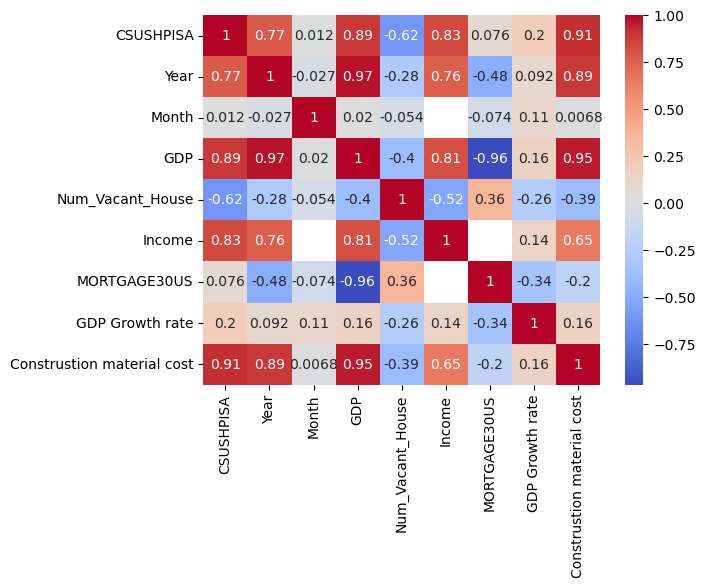

In [176]:
corr = data_final.corr()
sns.heatmap(corr,annot=True,cmap='coolwarm')
plt.show()

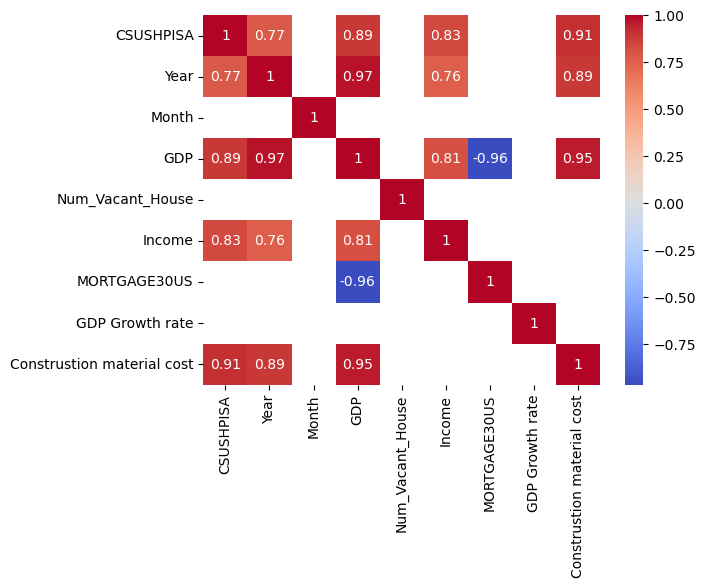

In [177]:
sns.heatmap(corr[abs(corr)>=0.7],annot=True,cmap='coolwarm')
plt.show()

#### Inferences 
- Before preprocessing :
- high correlation between GDP and Construction material cost 0.95
- Mortage rate and GdP has -0.96 correlation value.
- High correlation between GDP and Income 0.81. 


### EDA 

In [178]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import plotly

In [179]:
def plot_line_chart(df, x, y, title):

  trace_high = go.Scatter(
      x = df[x],
      y = df[y],
      name = title,
      line = dict(color = '#0047AB', width=3),
      opacity = 0.8)

  data = [trace_high]


  layout = dict(
      title = title,
      xaxis = dict(
          rangeselector = dict(
              buttons = list([
                  dict(count = 6,
                      label = '6 months',
                      step = 'month',
                      stepmode = 'backward'),
                  dict(count = 1,
                      label = '1 year',
                      step = 'year',
                      stepmode = 'backward'),
                  dict(count = 2,
                      label = '2 years',
                      step = 'year',
                      stepmode = 'backward'),
                  dict(count = 5,
                      label = '5 years',
                      step = 'year',
                      stepmode = 'backward'),
                  dict(count = 10,
                      label = '10 years',
                      step = 'year',
                      stepmode = 'backward'),
                  dict(count = 15,
                      label = '15 years',
                      step = 'year',
                      stepmode = 'backward'),
                  dict(step = 'all')
              ])
          ),
          rangeslider = dict(
              visible = True
          ),
          type = 'date'
      )
  )

  fig = dict(data = data, layout = layout)
  iplot(fig, filename = title)

In [180]:
plot_line_chart(data, x='DATE', y='CSUSHPISA', title='S&P/Case-Shiller U.S. National Home Price Index')
plot_line_chart(data_gdp, x='DATE', y='GDP', title='USA GDP (in Billion Dollars) over the years')

In [181]:
plot_line_chart(data_morg, x='DATE', y='MORTGAGE30US', title='Morg Rate')
plot_line_chart(data_income, x='DATE', y='Income', title='Median Income of U.S Population')
plot_line_chart(data_housevacant, x='DATE', y='Num_Vacant_House', title='Housing Inventory')

plot_line_chart(data_cost, x='DATE', y='Construstion material cost', title='Construction material cost')

In [182]:
plot_line_chart(data_growth, x='DATE', y='GDP Growth rate', title='GDP Growth Rate')

In [183]:
correlation = data_final.corr()['CSUSHPISA']
correlation_table = pd.DataFrame(correlation).reset_index()
correlation_table.columns = ['Factors', 'Correlation with CSUSHPISA']
print(correlation_table)

                      Factors  Correlation with CSUSHPISA
0                   CSUSHPISA                    1.000000
1                        Year                    0.770408
2                       Month                    0.012056
3                         GDP                    0.887347
4            Num_Vacant_House                   -0.617213
5                      Income                    0.834385
6                MORTGAGE30US                    0.075864
7             GDP Growth rate                    0.198667
8  Construstion material cost                    0.913022


## PREPROCESSING NULL VALUES

In [184]:
data_final.isna().sum()

CSUSHPISA                       0
Year                            0
Month                           0
GDP                           166
Num_Vacant_House              166
Income                        229
MORTGAGE30US                  216
GDP Growth rate               167
Construstion material cost      0
dtype: int64

### USING linear Interpolation method for filling null values

In [185]:
# Filling missing values using linear interpolation
data_final["GDP"] = data_final["GDP"].interpolate(method = 'linear')
data_final["Income"] = data_final["Income"].interpolate(method = 'linear')
data_final["Num_Vacant_House"] = data_final["Num_Vacant_House"].interpolate(method = 'linear')
data_final["MORTGAGE30US"] = data_final["MORTGAGE30US"].interpolate(method = 'linear')
data_final["GDP Growth rate"] = data_final["GDP Growth rate"].interpolate(method = 'linear')
data_final.head(5)

# # to interpolate the missing values  
# df.interpolate(method ='linear', limit_direction ='forward') 

,CSUSHPISA,Year,Month,GDP,Num_Vacant_House,Income,MORTGAGE30US,GDP Growth rate,Construstion material cost
DATE,,,,,,,,,
2003-01-01,128.461,2003,1,11174.129000,14908.000000,65860.000000,NaN,NaN,144.4
2003-02-01,129.355,2003,2,11220.341333,15020.000000,65851.666667,NaN,NaN,145.2
2003-03-01,130.148,2003,3,11266.553667,15132.000000,65843.333333,NaN,NaN,145.2
2003-04-01,130.884,2003,4,11312.766000,15244.000000,65835.000000,NaN,5.1,145.9
2003-05-01,131.735,2003,5,11397.400333,15367.333333,65826.666667,NaN,6.5,145.8


In [186]:
data_final.isna().sum()

CSUSHPISA                     0
Year                          0
Month                         0
GDP                           0
Num_Vacant_House              0
Income                        0
MORTGAGE30US                  7
GDP Growth rate               3
Construstion material cost    0
dtype: int64

In [187]:
data_final.dropna(inplace = True)

In [188]:
data_final.isna().sum()

CSUSHPISA                     0
Year                          0
Month                         0
GDP                           0
Num_Vacant_House              0
Income                        0
MORTGAGE30US                  0
GDP Growth rate               0
Construstion material cost    0
dtype: int64

In [189]:
data_final.shape

(242, 9)

### Our dataset has been preprocessed . Saving it as "prepared_dataset.csv".

In [190]:
data_final.to_csv("Final_dataset.csv")

In [191]:
df_final = pd.read_csv("Final_dataset.csv").set_index("DATE")
df_final.head()

,CSUSHPISA,Year,Month,GDP,Num_Vacant_House,Income,MORTGAGE30US,GDP Growth rate,Construstion material cost
DATE,,,,,,,,,
2003-08-01,134.969,2003,8,11635.190667,15627.333333,65801.666667,6.1400,8.633333,147.2
2003-09-01,136.294,2003,9,11703.712333,15640.666667,65793.333333,6.0625,7.966667,149.0
2003-10-01,137.531,2003,10,11772.234000,15654.000000,65785.000000,5.9850,7.300000,149.6
2003-11-01,138.794,2003,11,11822.638333,15734.333333,65776.666667,5.9075,6.600000,150.2
2003-12-01,140.179,2003,12,11873.042667,15814.666667,65768.333333,5.8300,5.900000,149.7


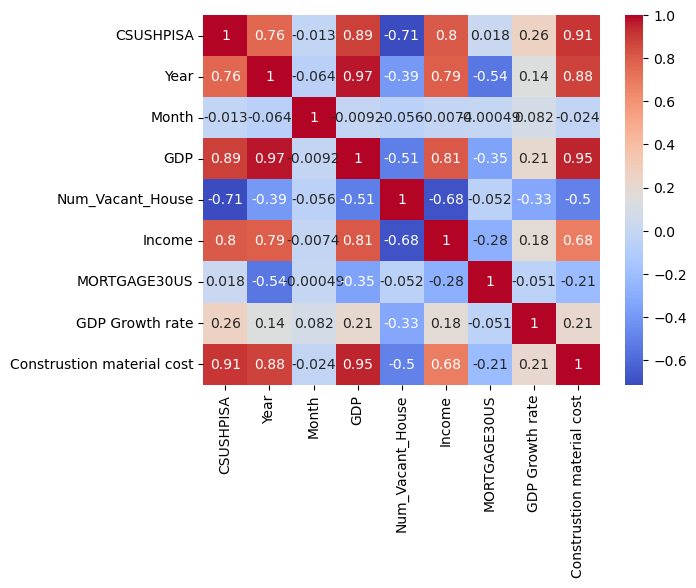

In [192]:
#Correlation after interpolation method 

corr = df_final.corr()
sns.heatmap(corr,annot=True,cmap='coolwarm')
plt.show()

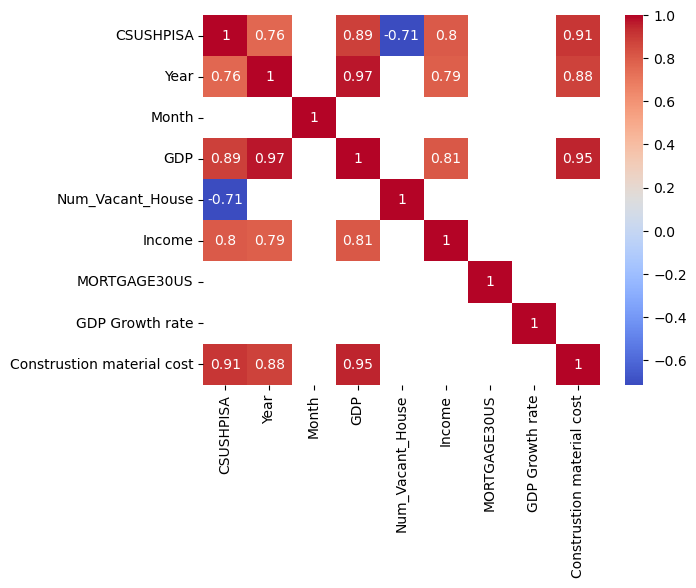

In [193]:
sns.heatmap(corr[abs(corr)>=0.7],annot=True,cmap='coolwarm')
plt.show()

In [194]:
correlation = df_final.corr()['CSUSHPISA']
correlation_table = pd.DataFrame(correlation).reset_index()
correlation_table.columns = ['Factors', 'Correlation with CSUSHPISA']
print(correlation_table)

                      Factors  Correlation with CSUSHPISA
0                   CSUSHPISA                    1.000000
1                        Year                    0.759816
2                       Month                   -0.012941
3                         GDP                    0.885303
4            Num_Vacant_House                   -0.714401
5                      Income                    0.801236
6                MORTGAGE30US                    0.018264
7             GDP Growth rate                    0.262151
8  Construstion material cost                    0.909783


### BASIC LINEAR REGRESSION MODEL with median income has factor  


### Data splitting and Scaling

In [195]:
df_final

,CSUSHPISA,Year,Month,GDP,Num_Vacant_House,Income,MORTGAGE30US,GDP Growth rate,Construstion material cost
DATE,,,,,,,,,
2003-08-01,134.969,2003,8,11635.190667,15627.333333,65801.666667,6.1400,8.633333,147.200
2003-09-01,136.294,2003,9,11703.712333,15640.666667,65793.333333,6.0625,7.966667,149.000
2003-10-01,137.531,2003,10,11772.234000,15654.000000,65785.000000,5.9850,7.300000,149.600
2003-11-01,138.794,2003,11,11822.638333,15734.333333,65776.666667,5.9075,6.600000,150.200
2003-12-01,140.179,2003,12,11873.042667,15814.666667,65768.333333,5.8300,5.900000,149.700
...,...,...,...,...,...,...,...,...,...
2023-05-01,302.566,2023,5,27249.855667,15090.000000,74580.000000,6.7400,5.500000,337.473
2023-06-01,304.593,2023,6,27436.699333,15131.000000,74580.000000,6.7900,7.200000,337.336
2023-07-01,306.767,2023,7,27623.543000,15172.000000,74580.000000,6.7900,8.900000,334.576


In [196]:
x = df_final.drop(columns=['CSUSHPISA', 'Year' ,'Month'], axis=1)
y = df_final['CSUSHPISA']
print(type(x))
print(type(y))
print(x.shape)
print(y.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(242, 6)
(242,)


### Split the data into train and test data

In [197]:
from sklearn.model_selection import train_test_split

In [198]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20, random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(193, 6)
(49, 6)
(193,)
(49,)


In [199]:
print(x_train)

                     GDP  Num_Vacant_House        Income  MORTGAGE30US  \
DATE                                                                     
2013-03-01  16701.854333      18263.000000  65600.000000      3.834444   
2020-10-01  22024.502000      15445.000000  76412.500000      2.880000   
2016-10-01  19089.379000      17328.000000  71777.500000      3.666667   
2014-08-01  17840.178333      17765.333333  66947.500000      4.212353   
2010-08-01  15197.562667      18805.666667  63745.833333      4.554286   
...                  ...               ...           ...           ...   
2012-06-01  16282.065667      18272.333333  64345.833333      3.708750   
2004-10-01  12527.214000      15361.000000  66525.000000      6.102857   
2011-04-01  15557.539000      18843.000000  63350.000000      4.348571   
2018-07-01  20798.730000      17221.000000  75640.000000      4.630000   
2012-02-01  16114.908333      18490.333333  63549.166667      3.933333   

            GDP Growth rate  Construs

In [200]:
print(x_test.head(5))

                     GDP  Num_Vacant_House        Income  MORTGAGE30US  \
DATE                                                                     
2005-08-01  13203.162667      15863.000000  67211.666667      5.745714   
2004-02-01  11986.569667      15956.333333  65845.000000      5.675000   
2016-04-01  18711.702000      17268.000000  71152.500000      3.637273   
2021-01-01  22600.185000      15602.000000  76330.000000      3.030000   
2023-05-01  27249.855667      15090.000000  74580.000000      6.740000   

            GDP Growth rate  Construstion material cost  
DATE                                                     
2005-08-01         6.533333                     165.900  
2004-02-01         5.633333                     153.400  
2016-04-01         4.100000                     212.700  
2021-01-01        10.900000                     256.400  
2023-05-01         5.500000                     337.473  


In [201]:
print(y_test.head(5))

DATE
2005-08-01    174.442
2004-02-01    143.192
2016-04-01    178.767
2021-01-01    239.560
2023-05-01    302.566
Name: CSUSHPISA, dtype: float64


In [202]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.linear_model import LassoCV

In [203]:
def eval_model(ytest,ypred):
    mae = mean_absolute_error(ytest,ypred)
    mse = mean_squared_error(ytest,ypred)
    rmse = np.sqrt(mse)
    r2s = r2_score(ytest,ypred)
    print('MAE',mae)
    print('MSE',mse)
    print('RMSE',rmse)
    print('R2 Score',r2s)
    
def mscore(model):
    print('Train Score',model.score(x_train,y_train))  # Train R2 Score
    print('Test Score',model.score(x_test,y_test))     # Test R2 Score

In [204]:
from sklearn.linear_model import LinearRegression

In [205]:
lr1 = LinearRegression()
lr1.fit(x_train,y_train) 

LinearRegression()

In [206]:
mscore(lr1)

Train Score 0.9753405778100711
Test Score 0.9782742485186939


In [207]:
#print regression coefficients
print(lr1.intercept_)

-140.6806991544864


In [208]:
print(lr1.coef_)

[-5.86304327e-04 -4.84011100e-03  3.16580178e-03  1.02956329e+01
  2.32354112e-01  6.86388916e-01]


In [209]:
ypred_lr1 =  lr1.predict(x_test)
eval_model(y_test,ypred_lr1)

MAE 5.493365059444946
MSE 50.52884772634824
RMSE 7.108364630936446
R2 Score 0.9782742485186939


In [210]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [211]:
# Convert both y_test and ypred_lr1_categorical to integers
y_test = y_test.astype(int)
ypred_lr1_categorical = ypred_lr1.astype(int)

# Now, use confusion_matrix and classification_report
cm = confusion_matrix(y_test, ypred_lr1_categorical)
print('Confusion Matrix\n', cm)
print('Classification Report\n', classification_report(y_test, ypred_lr1_categorical))


Confusion Matrix
 [[0 0 2 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]
Classification Report
               precision    recall  f1-score   support

         139       0.00      0.00      0.00         2
         142       0.00      0.00      0.00         1
         143       0.00      0.00      0.00         1
         144       0.00      0.00      0.00         1
         145       0.00      0.00      0.00         2
         146       0.00      0.00      0.00         1
         147       0.00      0.00      0.00         0
         148       0.00      0.00      0.00         4
         149       0.00      0.00      0.00         1
         150       0.00      0.00      0.00         1
         152       0.00      0.00      0.00         1
         153       0.00      0.00      0.00         0
         155       0.00      0.00      0.00         0
         156       0.00      0.00      0.00         0
         157       0.00     

In [212]:
threshold_y_test = 0.5  # Adjust the threshold based on your problem
y_test_binary = (y_test > threshold_y_test).astype(int)
cm = confusion_matrix(y_test_binary, ypred_lr1_categorical)
print('Confusion Matrix\n', cm)
print('Classification Report\n', classification_report(y_test_binary, ypred_lr1_categorical))


Confusion Matrix
 [[0 2 1 ... 2 2 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Classification Report
               precision    recall  f1-score   support

           1       0.00      0.00      0.00      49.0
         143       0.00      0.00      0.00       0.0
         144       0.00      0.00      0.00       0.0
         145       0.00      0.00      0.00       0.0
         146       0.00      0.00      0.00       0.0
         147       0.00      0.00      0.00       0.0
         148       0.00      0.00      0.00       0.0
         149       0.00      0.00      0.00       0.0
         152       0.00      0.00      0.00       0.0
         153       0.00      0.00      0.00       0.0
         155       0.00      0.00      0.00       0.0
         156       0.00      0.00      0.00       0.0
         157       0.00      0.00      0.00       0.0
         159       0.00      0.00      0.00       0.0
         162       0.00     

In [213]:
res_df = pd.DataFrame({'Actual_y_test':y_test,'Pred':ypred_lr1})
res_df.head(5)

,Actual_y_test,Pred
DATE,,
2005-08-01,174,162.124096
2004-02-01,143,148.542022
2016-04-01,178,174.419823
2021-01-01,239,221.917498
2023-05-01,302,308.719054


In [214]:
# saving the dataframe to plot into graph 
res_df.to_csv('Homell_with income.csv')

In [215]:
import plotly.express as px

# Assuming res_df contains 'Actual_y_test' and 'Pred' columns
fig = px.scatter(res_df, x='Actual_y_test', y='Pred', title='Actual vs. Predicted values',
                 labels={'Actual_y_test': 'Actual Values', 'Pred': 'Predicted Values'})
fig.show()


In [216]:
print(res_df.columns)

Index(['Actual_y_test', 'Pred'], dtype='object')


In [217]:
import plotly.graph_objects as go

# Create a figure
fig = go.Figure()

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=res_df.index, y=res_df['Actual_y_test'], mode='markers', name='Actual Values',
                         marker=dict(size=4)))

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=res_df.index, y=res_df['Pred'], mode='markers', name='Predicted Values',
                         marker=dict(size=4)))

# Set titles and labels
fig.update_layout(title='Actual vs. Predicted values over Time', xaxis_title='Date', yaxis_title='Values', 
                  autosize=True, width=900, height=300)

# Show the figure
fig.show()

### TUNNING BASIC MODEL 

In [218]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_sc = scaler.fit_transform(x_train)
x_test_sc = scaler.transform(x_test)  

In [219]:
lasso_cv_model = LassoCV(alphas=np.logspace(-4, 4, 100),cv=5)
lasso_cv_model.fit(x_train_sc, y_train)
lasso_cv_predictions = lasso_cv_model.predict(x_test_sc)

In [220]:
optimal_alpha = lasso_cv_model.alpha_

mse = mean_squared_error(y_test, lasso_cv_predictions)

rmse = np.sqrt(mse)

r2 = r2_score(y_test, lasso_cv_predictions)

print(f"Optimal Alpha: {optimal_alpha:.4f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"RMSE: {rmse:2f}")
print(f"R-squared (R2): {r2:.2f}")

Optimal Alpha: 0.2477
Mean Squared Error (MSE): 49.47
RMSE: 7.033229
R-squared (R2): 0.98


#### Cross Validation
#### Used to check robustness of the model

In [221]:
from sklearn.model_selection import cross_val_score

In [222]:
model_lr  = LinearRegression()
cv_res = cross_val_score(model_lr,x,y,scoring='r2',cv=5)  # cv = number of splits
print(cv_res)  # we will get 5 different R2 scores for 5 differnet splits
print(cv_res.mean())

[ 0.41090803  0.77275415  0.71639188 -1.58183654 -0.70036164]
-0.07642882237431592


In [223]:
cross_val_scores = cross_val_score(lasso_cv_model, x_train_sc, y_train, cv=5, scoring='r2')
print("Cross-Validation R-squared Scores:")
print(cross_val_scores)     

Cross-Validation R-squared Scores:
[0.98175733 0.96764296 0.95411014 0.9786769  0.97684151]


In [224]:

mean_r2 = cross_val_scores.mean()
std_r2 = cross_val_scores.std()

print(f"Mean R-squared: {mean_r2:.4f}")
print(f"Standard Deviation of R-squared: {std_r2:.4f}")
     

Mean R-squared: 0.9718
Standard Deviation of R-squared: 0.0100


In [225]:
print(0.1 * rmse)
print(0.1 * df_final['CSUSHPISA'].mean()) # rmse should be less than the 10% of mean of target variable

0.7033229030569772
18.664628512396696


## Most Prominent features and least prominent features

In [226]:
# coefficients and corresponding feature names
lasso_coefficients = lasso_cv_model.coef_
feature_names = x.columns

coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lasso_coefficients})

non_zero_coefficients_df = coefficients_df[coefficients_df['Coefficient'] != 0]
zero_coefficients_df = coefficients_df[coefficients_df['Coefficient'] == 0]
     

In [227]:
non_zero_coefficients_df

,Feature,Coefficient
1,Num_Vacant_House,-6.933111
2,Income,13.558678
3,MORTGAGE30US,10.947256
4,GDP Growth rate,0.976560
5,Construstion material cost,30.990915


In [228]:
zero_coefficients_df

,Feature,Coefficient
0,GDP,0.0


### Predicted vs Observed

In [229]:
import plotly.express as px

# Assuming y_test and lasso_cv_predictions are your actual and predicted values
fig = px.scatter(x=y_test, y=lasso_cv_predictions, labels={'x': 'Observed Values', 'y': 'Predicted Values'},
                 title="Predicted vs. Observed Values", opacity=0.5)

# Add a diagonal line for reference (perfect predictions)
fig.add_shape(
    type='line',
    x0=min(y_test), y0=min(y_test),
    x1=max(y_test), y1=max(y_test),
    line=dict(color='red', dash='dash')
)



# Show the plot
fig.show()


## Create Function to Evalaute other Regression model 

In [230]:
def eval_model(ytest,ypred):
    mae = mean_absolute_error(ytest,ypred)
    mse = mean_squared_error(ytest,ypred)
    rmse = mean_squared_error(ytest,ypred,squared=False)
    r2s = r2_score(ytest,ypred)
    return {'MAE':mae,'MSE':mse,'RMSE':rmse}

def model_res(model,x_train,x_test,y_train,y_test,ypred,mname):
    train_r2 = model.score(x_train,y_train)
    test_r2 = model.score(x_test,y_test)
    w = eval_model(y_test,ypred)
    res_metrics = {'Train_R2':train_r2,'Test_R2':test_r2,'Test_MSE':w['MSE'],
                    'Test_RMSE':w['RMSE'],'Test_MAE':w['MAE']}
    res = pd.DataFrame(res_metrics, index=[mname]) 
    return res, res_metrics

In [231]:
lr2 = LinearRegression()
lr2.fit(x_train,y_train)

LinearRegression()

In [232]:
ypred_lr2 = lr2.predict(x_test)

In [233]:
lr2_df,lr_res = model_res(lr2,x_train,x_test,y_train,y_test,ypred_lr2,'LinReg')
lr2_df

,Train_R2,Test_R2,Test_MSE,Test_RMSE,Test_MAE
LinReg,0.975341,0.978514,49.927752,7.065957,5.488418


### OTHER REGRESSION MODEL 

In [234]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

#### DecisonTree Regressor

In [235]:
# criterion= ' squared_error'
dt = DecisionTreeRegressor(max_depth=8,min_samples_split=10,min_samples_leaf=10)
dt.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=8, min_samples_leaf=10, min_samples_split=10)

In [236]:
ypred_dt = dt.predict(x_test)

In [237]:
dt1_df,dt1_res = model_res(dt,x_train,x_test,y_train,y_test,ypred_dt,'DTree_Reg')
dt1_df

,Train_R2,Test_R2,Test_MSE,Test_RMSE,Test_MAE
DTree_Reg,0.985762,0.97301,62.71789,7.919463,5.207191


#### KNN Regressor

In [238]:
knn = KNeighborsRegressor(n_neighbors=17)
knn.fit(x_train,y_train)

KNeighborsRegressor(n_neighbors=17)

In [239]:
ypred_knn = knn.predict(x_test)

In [240]:
knn1_df,knn1_res = model_res(knn,x_train,x_test,y_train,y_test,ypred_knn,'KNN_Reg')
knn1_df

,Train_R2,Test_R2,Test_MSE,Test_RMSE,Test_MAE
KNN_Reg,0.989517,0.987957,27.985347,5.290118,4.123684


#### RandomForest Regressor

In [241]:
rf = RandomForestRegressor(n_estimators=75,max_depth=7,min_samples_split=10)
rf.fit(x_train,y_train)

RandomForestRegressor(max_depth=7, min_samples_split=10, n_estimators=75)

In [242]:
ypred_rf =  rf.predict(x_test)

In [243]:
rf1_df,rf1_res = model_res(rf,x_train,x_test,y_train,y_test,ypred_rf,'RF_Reg')
rf1_df

,Train_R2,Test_R2,Test_MSE,Test_RMSE,Test_MAE
RF_Reg,0.997198,0.993938,14.085686,3.75309,2.728027


#### AdaBoost Regressor

In [244]:
ada = AdaBoostRegressor(n_estimators=90,random_state=42)
ada.fit(x_train,y_train)

AdaBoostRegressor(n_estimators=90, random_state=42)

In [245]:
ypred_ada = ada.predict(x_test)

In [246]:
ada1_df,ada1_res = model_res(ada,x_train,x_test,y_train,y_test,ypred_ada,'AdaBoost_Reg')
ada1_df

,Train_R2,Test_R2,Test_MSE,Test_RMSE,Test_MAE
AdaBoost_Reg,0.992122,0.992029,18.523197,4.303858,3.542984


#### XGBoost Regressor

In [247]:
from xgboost import XGBRegressor

In [248]:
xgb1 = XGBRegressor()
xgb1.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [249]:
ypred_xgb = xgb1.predict(x_test)

In [250]:
xgb1_df,xgb1_res = model_res(xgb1,x_train,x_test,y_train,y_test,ypred_xgb,'XGBoost_Reg')
xgb1_df

,Train_R2,Test_R2,Test_MSE,Test_RMSE,Test_MAE
XGBoost_Reg,1.0,0.997706,5.330154,2.308713,1.617565


### Feature Importance

In [251]:
import xgboost

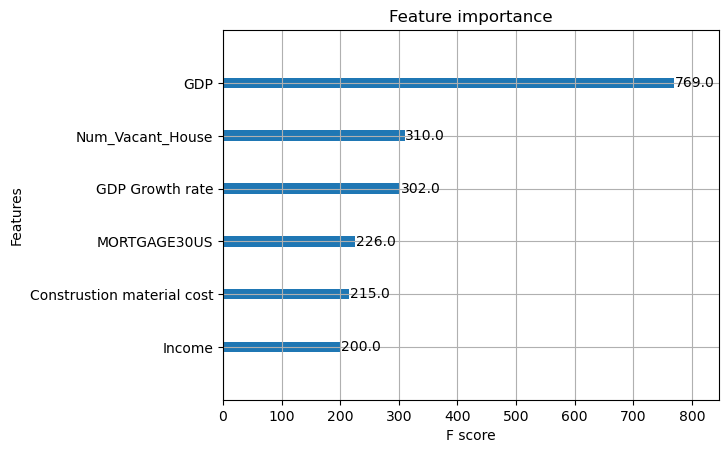

In [252]:
xgboost.plot_importance(xgb1)
plt.show()

In [253]:
all_res = pd.concat([lr2_df,dt1_df,knn1_df,rf1_df,ada1_df,xgb1_df])
all_res

,Train_R2,Test_R2,Test_MSE,Test_RMSE,Test_MAE
LinReg,0.975341,0.978514,49.927752,7.065957,5.488418
DTree_Reg,0.985762,0.973010,62.717890,7.919463,5.207191
KNN_Reg,0.989517,0.987957,27.985347,5.290118,4.123684
RF_Reg,0.997198,0.993938,14.085686,3.753090,2.728027
AdaBoost_Reg,0.992122,0.992029,18.523197,4.303858,3.542984
XGBoost_Reg,1.000000,0.997706,5.330154,2.308713,1.617565


### Best Performing  model on Entire
### XGBoost => Lowest Test_RMSE compared to other models, Highest test_R2 compared to other models

In [254]:
### exporting xgboost ouput 

res_df_xgboost = pd.DataFrame({'Actual_y_test':y_test,'Pred':ypred_xgb})
res_df_xgboost.head(5)

,Actual_y_test,Pred
DATE,,
2005-08-01,174,172.597977
2004-02-01,143,139.662064
2016-04-01,178,178.518082
2021-01-01,239,237.194611
2023-05-01,302,299.677307


In [255]:
# saving the dataframe to plot into graph 
res_df_xgboost.to_csv('Homellc_xgboostincome.csv')

## NOW out of three factors having high correlation with HOME PRIce index 
- Median Income - 0.83
- GDP  - 0.89
- Construstion Cost Material - 0.91

### We can remove median income before modelling as data frequency is YEARLY <br>, which is less compare to other factors GDP(quarterly) and construction material cost(weekly). 

### BASIC LINEAR REGRESSION MODEL WITHOUT median income has factor  

In [256]:
df_final

,CSUSHPISA,Year,Month,GDP,Num_Vacant_House,Income,MORTGAGE30US,GDP Growth rate,Construstion material cost
DATE,,,,,,,,,
2003-08-01,134.969,2003,8,11635.190667,15627.333333,65801.666667,6.1400,8.633333,147.200
2003-09-01,136.294,2003,9,11703.712333,15640.666667,65793.333333,6.0625,7.966667,149.000
2003-10-01,137.531,2003,10,11772.234000,15654.000000,65785.000000,5.9850,7.300000,149.600
2003-11-01,138.794,2003,11,11822.638333,15734.333333,65776.666667,5.9075,6.600000,150.200
2003-12-01,140.179,2003,12,11873.042667,15814.666667,65768.333333,5.8300,5.900000,149.700
...,...,...,...,...,...,...,...,...,...
2023-05-01,302.566,2023,5,27249.855667,15090.000000,74580.000000,6.7400,5.500000,337.473
2023-06-01,304.593,2023,6,27436.699333,15131.000000,74580.000000,6.7900,7.200000,337.336
2023-07-01,306.767,2023,7,27623.543000,15172.000000,74580.000000,6.7900,8.900000,334.576


In [257]:
# removing Income and other factors out of train data 

x2 = df_final.drop(columns=['CSUSHPISA', 'Year' ,'Month','Income'], axis=1)
y2 = df_final['CSUSHPISA']
print(type(x2))
print(type(y2))
print(x2.shape)
print(y2.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(242, 5)
(242,)


In [258]:
x2_train,x2_test,y2_train,y2_test = train_test_split(x2,y2,test_size=0.20, random_state=42)
print(x2_train.shape)
print(x2_test.shape)
print(y2_train.shape)
print(y2_test.shape)

(193, 5)
(49, 5)
(193,)
(49,)


In [263]:
x2_train.head(2)

,GDP,Num_Vacant_House,MORTGAGE30US,GDP Growth rate,Construstion material cost
DATE,,,,,
2013-03-01,16701.854333,18263.0,3.834444,3.166667,209.8
2020-10-01,22024.502000,15445.0,2.880000,7.100000,246.4


In [264]:
def eval_model(ytest,ypred):
    mae = mean_absolute_error(ytest,ypred)
    mse = mean_squared_error(ytest,ypred)
    rmse = np.sqrt(mse)
    r2s = r2_score(ytest,ypred)
    print('MAE',mae)
    print('MSE',mse)
    print('RMSE',rmse)
    print('R2 Score',r2s)
    
def mscore(model):
    print('Train Score',model.score(x2_train,y2_train))  # Train R2 Score
    print('Test Score',model.score(x2_test,y2_test))     # Test R2 Score

In [265]:
lr_ni = LinearRegression()
lr_ni.fit(x2_train,y2_train) 

LinearRegression()

In [266]:
mscore(lr_ni)

Train Score 0.9606922761970201
Test Score 0.9668038615049208


In [267]:
print(lr_ni.intercept_)
print(lr_ni.coef_)

110.41415356710635
[ 5.42052560e-03 -8.99155184e-03  1.11472265e+01  7.34354974e-02
  3.63384970e-01]


In [268]:
ypred_lr_ni =  lr_ni.predict(x2_test)
eval_model(y2_test,ypred_lr_ni)

MAE 7.337732558653294
MSE 77.2061960003508
RMSE 8.7867056397919
R2 Score 0.9668038615049208


In [269]:
res_df2 = pd.DataFrame({'Actual_y_test':y2_test,'Pred':ypred_lr_ni})
res_df2.head(5)

,Actual_y_test,Pred
DATE,,
2005-08-01,174.442,164.163372
2004-02-01,143.192,151.332915
2016-04-01,178.767,174.713868
2021-01-01,239.560,220.381293
2023-05-01,302.566,320.608995


In [270]:
# saving the dataframe to plot into graph 
res_df2.to_csv('Homellc_no_i.csv')

## EXPERIMENT MORE WITH BASIC LINEAR REGRESSION MODEL with income factor including 

## OLS MODEL 

In [271]:
import statsmodels.api as sm

In [272]:
x1 = x.copy()
y1= y.copy()

In [273]:
print(x1.shape)
print(y1.shape)

(242, 6)
(242,)


In [274]:
x1.head(2)

,GDP,Num_Vacant_House,Income,MORTGAGE30US,GDP Growth rate,Construstion material cost
DATE,,,,,,
2003-08-01,11635.190667,15627.333333,65801.666667,6.1400,8.633333,147.2
2003-09-01,11703.712333,15640.666667,65793.333333,6.0625,7.966667,149.0


In [275]:
x1=sm.add_constant(x1)
ols_model = sm.OLS(y1,x1).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              CSUSHPISA   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1601.
Date:                Wed, 13 Dec 2023   Prob (F-statistic):          1.75e-187
Time:                        11:27:00   Log-Likelihood:                -818.90
No. Observations:                 242   AIC:                             1652.
Df Residuals:                     235   BIC:                             1676.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       -134.2073     24.050     -5.580      0.000    -181.589     -86.825
GDP                           -0.0004      0.001     -0.594      0.553      -0.002       0.001
Num_Vacant_House              -0.0051      0.001     -9.037      0.000      -0.006      -0.004
Income                         0.0031      0.000     11.662      0.000       0.003       0.004
MORTGAGE30US                  10.0248      0.518     19.336      0.000       9.003      11.046
GDP Growth rate                0.2479      0.096      2.574      0.011       0.058       0.438
Construstion material cost     0.6704      0.044     15.174      0.000       0.583       0.757
==============================================================================
Omnibus:                        5.854   Durbin-Watson:                   0.083
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                5.869
Skew:                          -0.284   Prob(JB):                       0.0532
Kurtosis:                       3.510   Cond. No.                     3.82e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.82e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [276]:
print(ols_model.rsquared)
print(ols_model.rsquared_adj)

0.9761219574455392
0.9755123052952125


### OLS not fitted for this dataset , as it score has decreased than basic model

### Checking multicollinearity using VIF
- as this is regression We can except high multicollineartiy as GDP effects Constuction material cost , income , and many other factrors directly and indirectly.

In [277]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [278]:
[variance_inflation_factor(x.values,i) for i in range (x.shape[1])]

[459.0844975665706,
 93.21292960187492,
 295.8024368998106,
 28.914964131747542,
 1.9721886409417562,
 334.80616597470356]

In [279]:
vif = pd.DataFrame()
vif['Features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
# i=0,1,2
vif = vif.sort_values(by='VIF',ascending=False)                
vif

,Features,VIF
0,GDP,459.084498
5,Construstion material cost,334.806166
2,Income,295.802437
1,Num_Vacant_House,93.212930
3,MORTGAGE30US,28.914964
4,GDP Growth rate,1.972189
